In [5]:
import os


Wczytano model: models/raft-sintel.pth
torch.Size([1, 3, 240, 320])


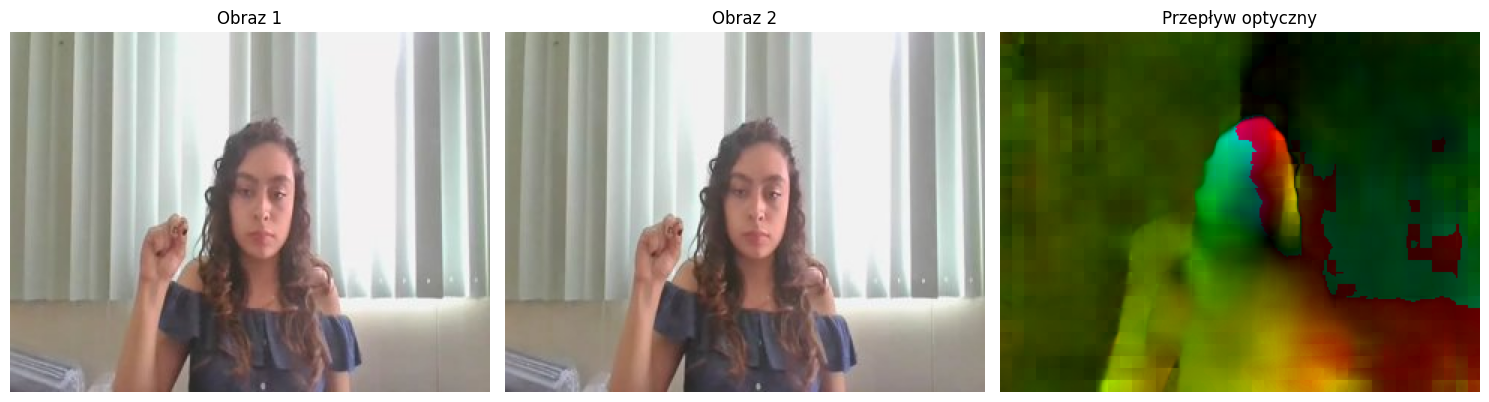

In [6]:
from argparse import Namespace
from collections import namedtuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from core.raft import RAFT


def load_image(img_path):
    """Wczytuje obraz i konwertuje go do formatu wymaganego przez RAFT."""
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Nie można wczytać obrazu: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img).permute(2, 0, 1).float()  # HWC -> CHW
    img = img[None].cuda()  # Dodaj wymiar batch i przenieś na GPU
    return img

def flow_to_color(flow):
    """Konwertuje przepływ optyczny na kolorową wizualizację."""
    u, v = flow[:, :, 0], flow[:, :, 1]
    mag = np.sqrt(u**2 + v**2)
    ang = np.arctan2(v, u)
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 1] = 255
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue (kierunek)
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value (magnituda)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

def main():
    # Definicja parametrów dla RAFT za pomocą Namespace (mutowalny obiekt)
    args = Namespace(
        small=False,  # Używamy mniejszego modelu (raft-small.pth)
        mixed_precision=True,  # Wyłącz mieszaną precyzję dla prostoty
        alternate_corr=False,  # Standardowa korelacja
        dropout=0.0,  # Brak dropout dla inferencji
        corr_levels=4,  # Liczba poziomów w piramidzie korelacji
        corr_radius=3,  # Promień korelacji
        n_downsample=2,  # Liczba warstw downsamplingu
        context_dim=64,  # Wymiar kontekstu dla mniejszego modelu
        hidden_dim=96,  # Wymiar ukryty dla GRU
        n_gru_layers=2  # Liczba warstw GRU
    )

    # Ścieżki do obrazów i modelu
    image1_path = "data/159/000100.jpg"
    image2_path = "data/159/000110.jpg"
    model_path = "models/raft-sintel.pth"
    iters = 20  # Liczba iteracji RAFT

    # Inicjalizacja modelu RAFT
    model = RAFT(args)
    model = model.cuda()
    model.eval()

    # Wczytanie pretrenowanego modelu
    try:
        checkpoint = torch.load(model_path, map_location='cuda:0')
        # Dopasowanie wag, jeśli model był trenowany w trybie DataParallel
        state_dict = checkpoint
        if 'module' in list(state_dict.keys())[0]:
            state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
        model.load_state_dict(state_dict)
        print(f"Wczytano model: {model_path}")
    except Exception as e:
        raise ValueError(f"Błąd wczytywania modelu: {e}")

    # Wczytanie obrazów
    img1 = load_image(image1_path)
    print(img1.shape)
    img2 = load_image(image2_path)

    # Sprawdzenie zgodności rozmiarów
    if img1.shape != img2.shape:
        raise ValueError("Obrazy muszą mieć ten sam rozmiar!")

    # Obliczenie przepływu optycznego
    with torch.no_grad():
        _, flow = model(img1, img2, iters=iters, test_mode=True)
    
    # Konwersja przepływu na numpy
    flow = flow[0].permute(1, 2, 0).cpu().numpy()  # [H, W, 2]

    # Wizualizacja przepływu
    flow_rgb = flow_to_color(flow)

    # Wyświetlenie wyników
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title("Obraz 1")
    plt.imshow(cv2.cvtColor(cv2.imread(image1_path), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Obraz 2")
    plt.imshow(cv2.cvtColor(cv2.imread(image2_path), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Przepływ optyczny")
    plt.imshow(flow_rgb)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


In [7]:
import glob
import os

import cv2
import numpy as np


def create_mp4_animation(input_folder, output_file="animation.mp4", fps=24, max_duration=10):
    """
    Tworzy animację MP4 z obrazów w podanym katalogu, ograniczając czas trwania.
    
    Parametry:
    input_folder (str): Ścieżka do katalogu z obrazami
    output_file (str): Nazwa pliku wyjściowego
    fps (int): Liczba klatek na sekundę
    max_duration (float): Maksymalny czas trwania animacji w sekundach
    """
    # Pobierz listę wszystkich obrazów z katalogu (png, jpg, jpeg)
    image_files = sorted(glob.glob(os.path.join(input_folder, "*.[pP][nN][gG]")) +
                        glob.glob(os.path.join(input_folder, "*.[jJ][pP][gG]")) +
                        glob.glob(os.path.join(input_folder, "*.[jJ][pP][eE][gG]")))
    
    if not image_files:
        print("Brak obrazów w podanym katalogu!")
        return
    
    # Oblicz maksymalną liczbę klatek na podstawie czasu trwania
    max_frames = int(fps * max_duration)
    # Ogranicz listę obrazów do maksymalnej liczby klatek
    image_files = image_files[:max_frames]
    
    if not image_files:
        print("Brak obrazów po ograniczeniu liczby klatek!")
        return
    
    # Wczytaj pierwszy obraz, aby określić rozmiar
    img = cv2.imread(image_files[0])
    if img is None:
        print(f"Nie można wczytać obrazu {image_files[0]}!")
        return
    height, width, _ = img.shape
    
    # Zainicjuj writer dla MP4
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Kodek MP4
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))
    
    # Przetwarzaj obrazy
    for file in image_files:
        try:
            img = cv2.imread(file)
            if img is None:
                print(f"Nie można wczytać obrazu {file}")
                continue
            
            # Sprawdź, czy rozmiar obrazu jest zgodny
            if img.shape[:2] != (height, width):
                img = cv2.resize(img, (width, height))
            
            out.write(img)
        except Exception as e:
            print(f"Błąd przy przetwarzaniu {file}: {e}")
    
    # Zwolnij zasoby
    out.release()
    print(f"Animacja zapisana jako {output_file}")

# Przykład użycia
if __name__ == "__main__":
    # Podaj ścieżkę do katalogu z obrazami
    input_folder = "data/159/"
    create_mp4_animation(input_folder, "wynikowa_animacja.mp4", fps=24, max_duration=10)


Animacja zapisana jako wynikowa_animacja.mp4


228 223 ['198', '143', '222']
Train dataset size: 594
Validation dataset size: 198
Test dataset size: 198
Epoch 1/10, Train Loss: 0.0780, Val Loss: 0.0088
Best model saved with Val Loss: 0.0088
Epoch 2/10, Train Loss: 0.0060, Val Loss: 0.0041
Best model saved with Val Loss: 0.0041
Epoch 3/10, Train Loss: 0.0035, Val Loss: 0.0038
Best model saved with Val Loss: 0.0038
Epoch 4/10, Train Loss: 0.0026, Val Loss: 0.0024
Best model saved with Val Loss: 0.0024
Epoch 5/10, Train Loss: 0.0023, Val Loss: 0.0021
Best model saved with Val Loss: 0.0021
Epoch 6/10, Train Loss: 0.0022, Val Loss: 0.0024
Epoch 7/10, Train Loss: 0.0022, Val Loss: 0.0016
Best model saved with Val Loss: 0.0016
Epoch 8/10, Train Loss: 0.0019, Val Loss: 0.0014
Best model saved with Val Loss: 0.0014
Epoch 9/10, Train Loss: 0.0018, Val Loss: 0.0014
Best model saved with Val Loss: 0.0014
Epoch 10/10, Train Loss: 0.0018, Val Loss: 0.0016
PSNR between interpolated frame and ground truth (test set): 34.09 dB


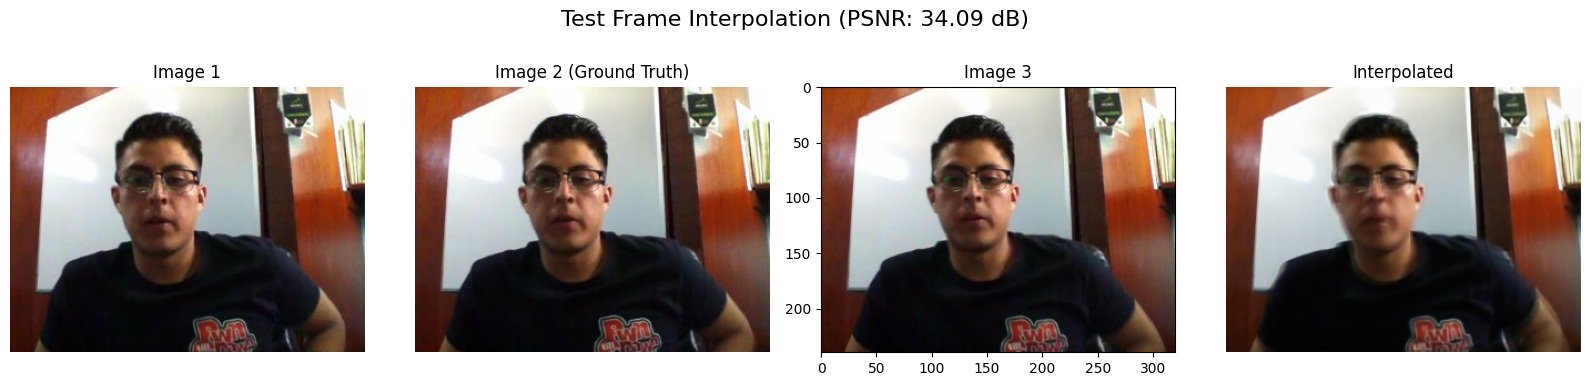

In [ ]:
import os
from typing import Generator, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms


class FrameDataset(Dataset):
    def __init__(self, dir_names: list[str], root_path: str = "data"):
        self._root_path = root_path
        self._transform = transforms.Compose([
            transforms.ToTensor(),  # Convert PIL Image to tensor (scales to [0, 1])
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Scale to [-1, 1]
        ])
        self._data = self._get_frames(dir_names)

    def _get_frame_triples(self, file_names: list[str]) -> Generator[Tuple[str, str, str], None, None]:
        for i in range(len(file_names) - 2):
            yield (file_names[i], file_names[i + 1], file_names[i + 2])

    def _get_frames(self, dir_names: list[str]) -> list[Tuple[str, str, str]]:
        frames = []
        for dir_name in dir_names:
            dir_path = os.path.join(self._root_path, dir_name)
            if not os.path.isdir(dir_path):
                print(f"Warning: {dir_path} is not a directory, skipping.")
                continue
            file_names = sorted(
                [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            )[:200]  # Limit to 20 frames per sequence
            file_names = [os.path.join(dir_path, file_name) for file_name in file_names]
            frames.extend(self._get_frame_triples(file_names))
        return frames

    def __len__(self) -> int:
        return len(self._data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        if idx < 0 or idx >= len(self._data):
            raise IndexError("Index out of range")
        try:
            img1 = Image.open(self._data[idx][0]).convert('RGB')
            img2 = Image.open(self._data[idx][1]).convert('RGB')
            img3 = Image.open(self._data[idx][2]).convert('RGB')
            img1 = self._transform(img1)
            img2 = self._transform(img2)
            img3 = self._transform(img3)
            return img1, img2, img3
        except Exception as e:
            raise RuntimeError(f"Error loading images at index {idx}: {e}")


def denormalize(tensor: torch.Tensor) -> np.ndarray:
    """Convert tensor from [-1, 1] to [0, 255] and format for OpenCV (H, W, C)."""
    denorm = transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2))
    img = denorm(tensor).permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    return img


def normalize(img: np.ndarray) -> torch.Tensor:
    """Convert OpenCV image (H, W, C, [0, 255]) to tensor (C, H, W, [-1, 1])."""
    img = img.astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1)
    transform = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    return transform(img)


def calculate_psnr(img1: torch.Tensor, img2: torch.Tensor) -> float:
    """
    Calculate PSNR between two images.
    Args:
        img1, img2: Torch tensors (C, H, W) in range [-1, 1].
    Returns:
        PSNR value in dB.
    """
    denorm = transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2))
    img1 = img1.cpu()
    img2 = img2.cpu()
    img1 = denorm(img1).clamp(0, 1)
    img2 = denorm(img2).clamp(0, 1)
    img1_np = (img1.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    img2_np = (img2.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    mse = np.mean((img1_np - img2_np) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel) - 10 * np.log10(mse)
    return psnr


def visualize_quadruple(
    triple: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], interpolated: torch.Tensor, title: str = "Image Triple with Interpolation"
) -> None:
    """Visualize original triple and interpolated frame."""
    denorm = transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2))
    img1, img2, img3 = [denorm(img).permute(1, 2, 0).numpy() for img in triple]
    interpolated = interpolated.cpu()
    img_interpolated = denorm(interpolated).permute(1, 2, 0).numpy()

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    fig.suptitle(title, fontsize=16)
    axes[0].imshow(img1)
    axes[0].set_title("Image 1")
    axes[0].axis('off')
    axes[1].imshow(img2)
    axes[1].set_title("Image 2 (Ground Truth)")
    axes[1].axis('off')
    axes[2].imshow(img3)
    axes[2].set_title("Image 3")
    axes[2].axis('off')
    axes[3].imshow(img_interpolated)
    axes[3].set_title("Interpolated")
    axes[3].axis('off')
    plt.tight_layout()
    plt.show()


class FrameInterpolationModel(nn.Module):
    def __init__(self):
        super(FrameInterpolationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, frame1: torch.Tensor, frame3: torch.Tensor) -> torch.Tensor:
        x = torch.cat([frame1, frame3], dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        return x


def train_model(
    model: nn.Module,
    train_dataset: FrameDataset,
    val_dataset: FrameDataset,
    num_epochs: int = 100,
    batch_size: int = 8,
    learning_rate: float = 0.001
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for frame1, frame2, frame3 in train_loader:
            frame1, frame2, frame3 = frame1.to(device), frame2.to(device), frame3.to(device)
            optimizer.zero_grad()
            outputs = model(frame1, frame3)
            loss = criterion(outputs, frame2)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * frame1.size(0)

        train_loss = train_loss / len(train_dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for frame1, frame2, frame3 in val_loader:
                frame1, frame2, frame3 = frame1.to(device), frame2.to(device), frame3.to(device)
                outputs = model(frame1, frame3)
                loss = criterion(outputs, frame2)
                val_loss += loss.item() * frame1.size(0)
        
        val_loss = val_loss / len(val_dataset)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "frame_interpolation_model.pth")
            print(f"Best model saved with Val Loss: {best_val_loss:.4f}")


def load_model(model: nn.Module, path: str = "frame_interpolation_model.pth") -> nn.Module:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    model.eval()
    return model


def test_model(model: nn.Module, test_dataset: FrameDataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Test on first triple
    first_triple = test_dataset[0]
    frame1, frame2, frame3 = [x.unsqueeze(0) for x in first_triple]
    frame1, frame3 = frame1.to(device), frame3.to(device)

    with torch.no_grad():
        interpolated_frame = model(frame1, frame3).squeeze(0)

    psnr_value = calculate_psnr(interpolated_frame, first_triple[1])
    print(f"PSNR between interpolated frame and ground truth (test set): {psnr_value:.2f} dB")

    visualize_quadruple(first_triple, interpolated_frame, title=f"Test Frame Interpolation (PSNR: {psnr_value:.2f} dB)")


# Example usage
if __name__ == "__main__":
    try:
        # Get directory names
        data_dirs = os.listdir("data")
        if len(data_dirs) < 2:
            raise ValueError("At least two directories are required for validation and test sets.")

        # Define datasets
        print(data_dirs[0], data_dirs[1], data_dirs[2:5])
        val_dir = [data_dirs[0]]  # First directory for validation
        test_dir = [data_dirs[1]]  # Second directory for test
        train_dir = data_dirs[2:5]  # Remaining directories for training (or adjust as needed)

        train_dataset = FrameDataset(train_dir)
        val_dataset = FrameDataset(val_dir)
        test_dataset = FrameDataset(test_dir)

        print(f"Train dataset size: {len(train_dataset)}")
        print(f"Validation dataset size: {len(val_dataset)}")
        print(f"Test dataset size: {len(test_dataset)}")

        if len(train_dataset) == 0 or len(val_dataset) == 0 or len(test_dataset) == 0:
            raise ValueError("One or more datasets are empty.")

        # Initialize and train model
        model = FrameInterpolationModel()
        train_model(model, train_dataset, val_dataset, num_epochs=10, batch_size=8, learning_rate=0.001)

        # Load best model
        model = load_model(model)

        # Test model on test dataset
        test_model(model, test_dataset)

    except Exception as e:
        print(f"Error: {e}")
